# Time Series - Part 1 Basics
In this series of notebooks we provide a short introduction to mining of data series. In this first part, we examine the basic operations to work with series.

The content of this notebook is based on 
* Rob J Hyndman and George Athanasopoulos. Forecasting: Principles and Practice available at https://otexts.com/fpp2/
* Siddharth Yadav [Everything you can do with a time series](https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series#3.-Time-series-decomposition-and-Random-walks)
* Selva Prabhakaran [Time Series Analysis in Python – A Comprehensive Guide with Examples](https://www.machinelearningplus.com/time-series/time-series-analysis-python/)


## Libraries
First, we need to load the libraries we will be using throughout this notebook.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# select the style from fivethityeight website
mpl.rcdefaults() 
plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams.update({'font.size': 16})


np.random.seed(238746)

import warnings
warnings.filterwarnings('ignore')


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

## Time Series Patterns
When working with time series, we use terms like "trend", "seasonal", and "cyclic". A trend identify a long-term increase or decrease in the data. It does not have to be linear and can change direction from an increasing trend to a decreasing one or viceversa. When a time series is affected by seasonal factors (e.g., day of the week, time of the year) we say that the series has a seasonal pattern. Seasonality has usually a fixed and known frequency. When the data exhibit rises and falls that are not of a fixed frequency, we say that the series is cyclic. Fluctuations are usually due to economic conditions and their duration is usually at least 2 years. Cyclic behaviour and seasonal behaviour might look similar but in reality they are really quite different. If the fluctuations are not of a fixed frequency then they are cyclic; if the frequency is unchanging and associated with some aspect of the calendar, then the pattern is seasonal. In general, cycles are longer than seasonal patterns and cycle magnitudes tend to be more variable than the magnitudes of seasonal patterns.

Data series are different from other kind of data is that we have a series of data points that are not independent, i.e., they are correlated each other: what we observe in the future is somehow correlated with what we have seen in the past. The samples in a time-series have been collected during time, so we have this additional variable. We might have multiple observations in a single time step (e.g., temperature and humidity at time $t$). Of course time is not stricly necessary, but a sequence of events is sufficient (e.g., years).

## Plotting Time Series 
We can simply plot a time series as a function of time like in the three examples below showing a trend, a seasonal pattern of sunspots, and a combination of seasonality with a growing trend.

In a data-series we can spot two things:
1. Trend
2. Seasonality

These two might be both present in our data.

Plots:
1. Price: trend only
2. Sunspots: seasonality only
3. Antidiabetic drugs sales: either trend and seasonality

We want to identify them and remove them.  Remove the trend because if we have a trend the target (prediction) will try to fit the trend. Removing the trend, we may discover that if the increased of one year is less than another. Remove the seasonality to perform better predictions. If we do not know that there is a period we cannot exploit trend in the sub-periods and the model would not be able to make predictions. So the idea is to split data such that there is no seasonality.

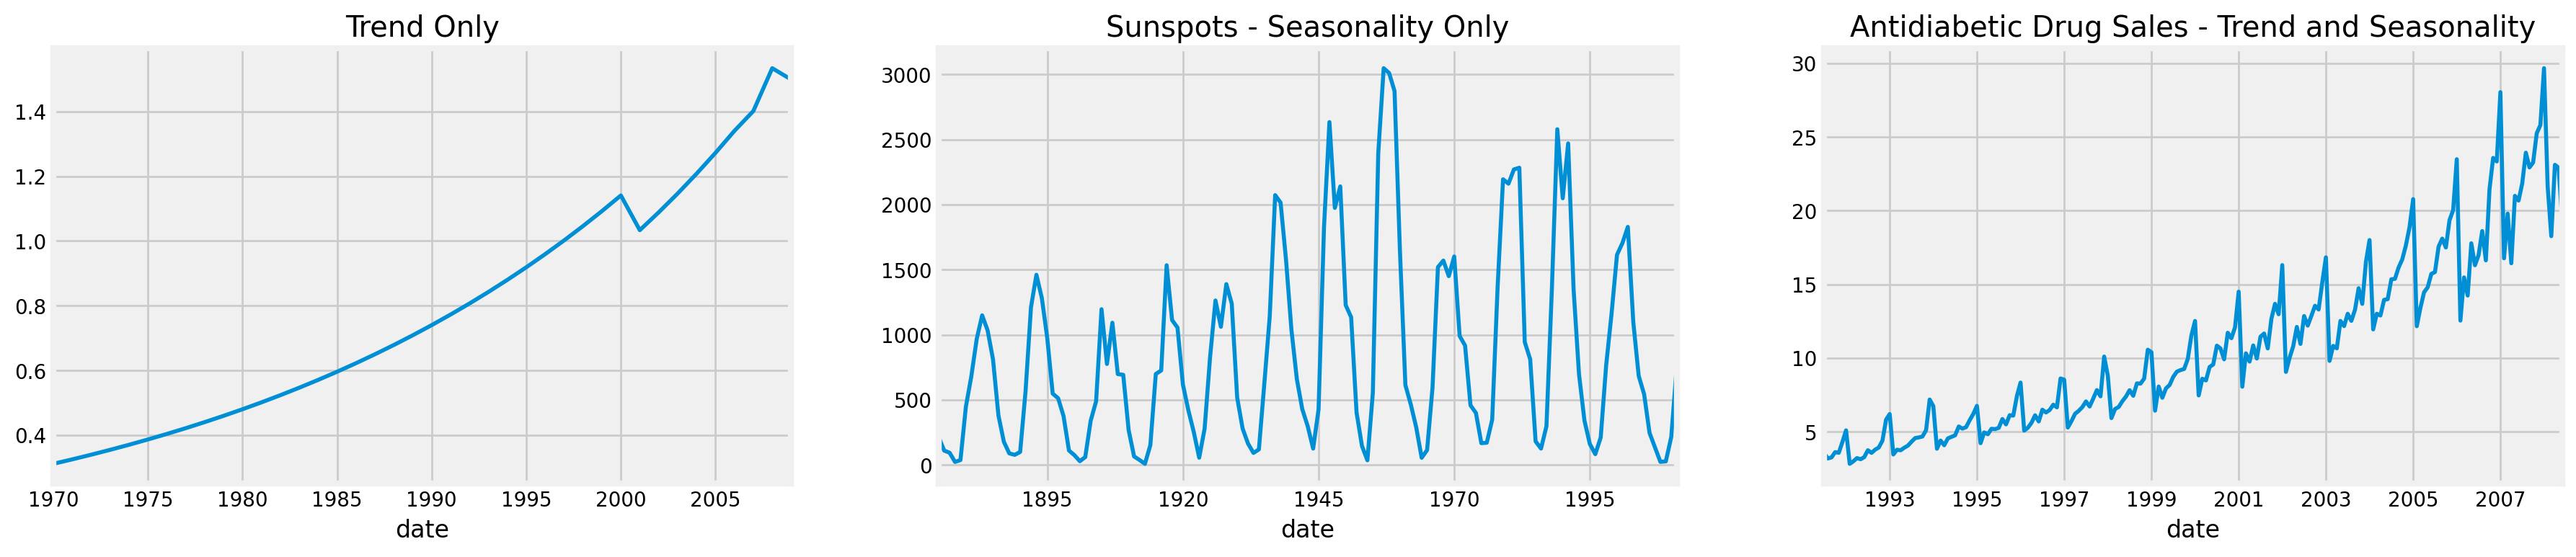

In [2]:
fig, axes = plt.subplots(1, 3, figsize=(20,4), dpi=100)
guinearice = pd.read_csv('others/guinearice.csv', parse_dates=['date'], index_col='date').plot(title='Trend Only', legend=False, ax=axes[0]);

pd.read_csv('others/sunspotarea.csv', parse_dates=['date'], index_col='date').plot(title='Sunspots - Seasonality Only', legend=False, ax=axes[1]);
pd.read_csv('others/a10.csv', parse_dates=['date'], index_col='date').plot(title='Antidiabetic Drug Sales - Trend and Seasonality', legend=False, ax=axes[2]);

You can plot a positive time series on both sides to emphasize the trend and growth.

Typical way to show data-series, especially in the case we have only positive values: instead of just representing the positive values we represent the opposite values. This allows to clearly see the trend of the series (from narrow to broader area). We can observe two things:
1. There is a general trend in this data: the sales in antidiabetic drugs are increasing during the years
2. Strange behaviour that is repeating over time: this data are collected in sequential years. Indeed, the data we are given are collected monthly. Therefore, it could be useful to plot data in every single year, as done below. 

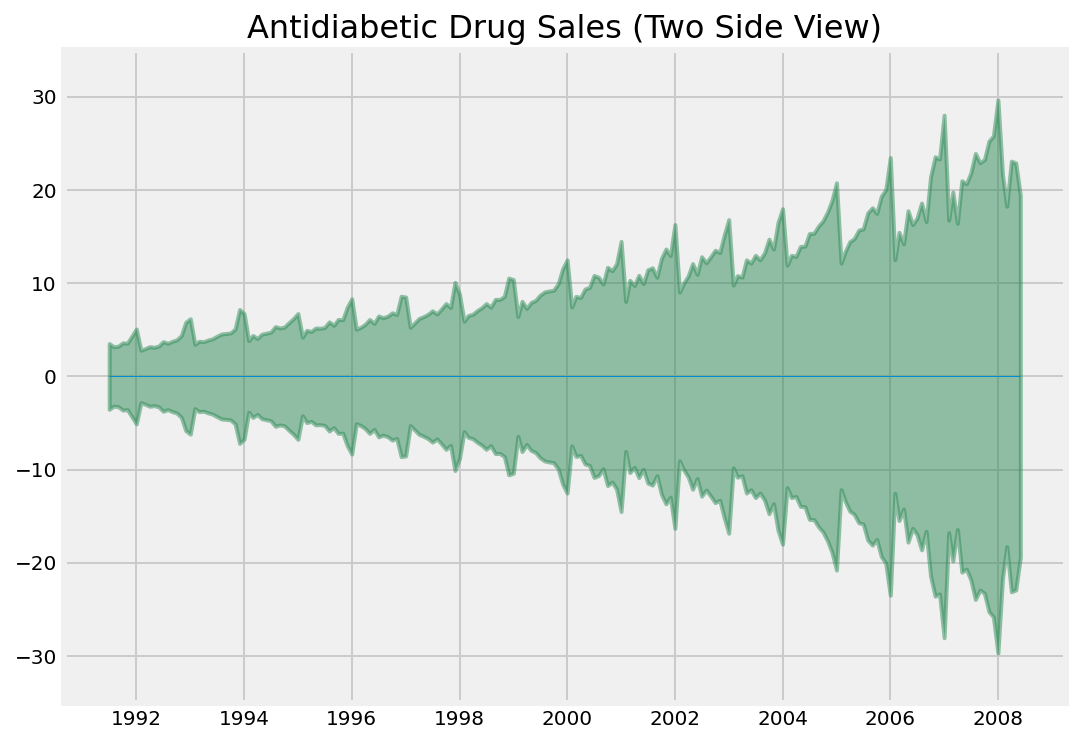

In [3]:
diabetic_drugs = pd.read_csv('others/a10.csv', parse_dates=['date']) # parse_dates = decompose years from the months

x = diabetic_drugs['date'].values
y = diabetic_drugs['value'].values

plt.figure(figsize=(8,6))
plt.fill_between(x, y1=y, y2=-y, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-35, 35)
plt.title('Antidiabetic Drug Sales (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(diabetic_drugs['date'].values), xmax=np.max(diabetic_drugs['date'].values), linewidth=.5)
plt.show()

Seasonal plots report the data against the individual “seasons” in which the data were observed. For example, we can report the antidiabetic drug sales overlapping the yearly (seasonal) trends.



There is a **seasonal** behaviour: something that repeat with a similar pattern and period. In our data, we have a peak in January, a decrease in February and then a slight increasing from March to December. If we have a domain expert we may ask him/her why this behaviour occurred. He/she can tell us that the trend is strange and so the problem could be a wrong acquisition. We need to be sure that data represent correctly the reality.

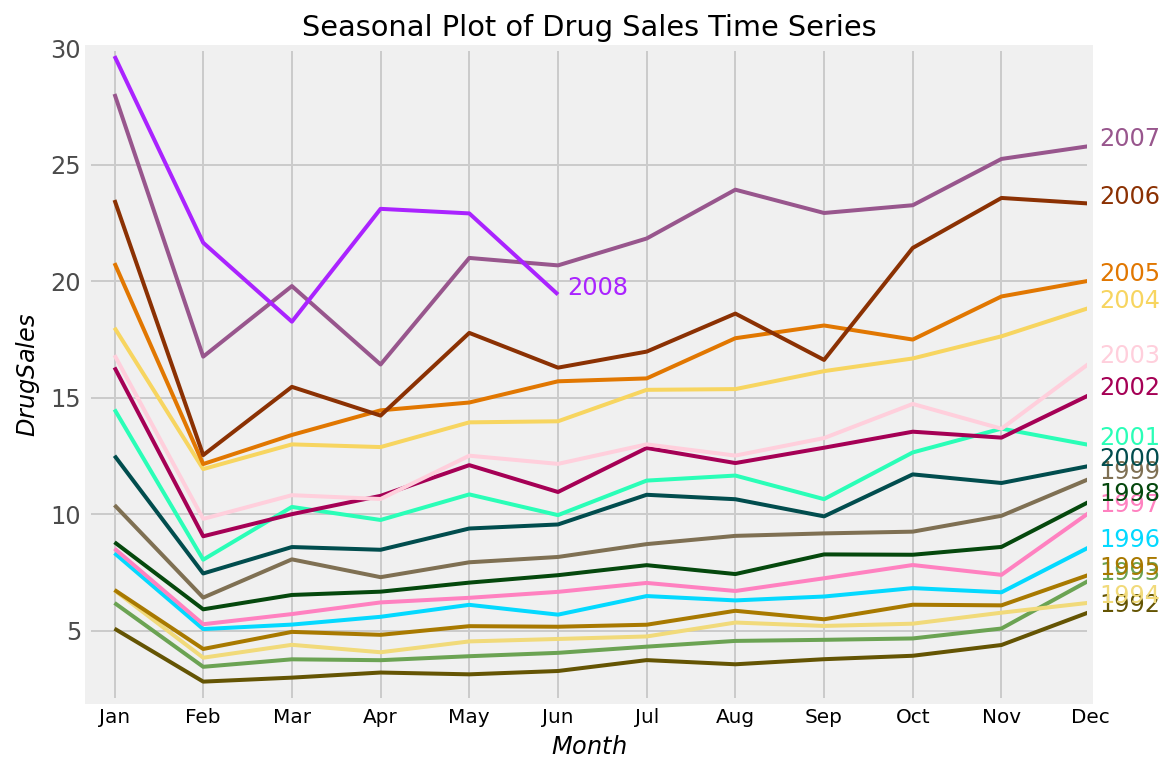

In [4]:
diabetic_drugs['year'] = [d.year for d in diabetic_drugs.date]
diabetic_drugs['month'] = [d.strftime('%b') for d in diabetic_drugs.date]
diabetic_drugs_years = diabetic_drugs['year'].unique()

# Prep Colors
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(diabetic_drugs_years), replace=False)

# Draw Plot
plt.figure(figsize=(8,6))
for i, y in enumerate(diabetic_drugs_years):
    if i > 0:        
        plt.plot('month', 'value', data=diabetic_drugs.loc[diabetic_drugs.year==y, :], color=mycolors[i], label=y)
        plt.text(diabetic_drugs.loc[diabetic_drugs.year==y, :].shape[0]-.9, diabetic_drugs.loc[diabetic_drugs.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Drug Sales$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series")
plt.show()

You can group the data at seasonal intervals and check their distributed within a given year or month and how it compares over time.

Instead of just showing the line plot for each year we represent each point with a box-plot. Each single box-plot represent the sales done in that month for all the years (from 1992 to 2008). This allows us to see there is a pattern (as enlighted before).

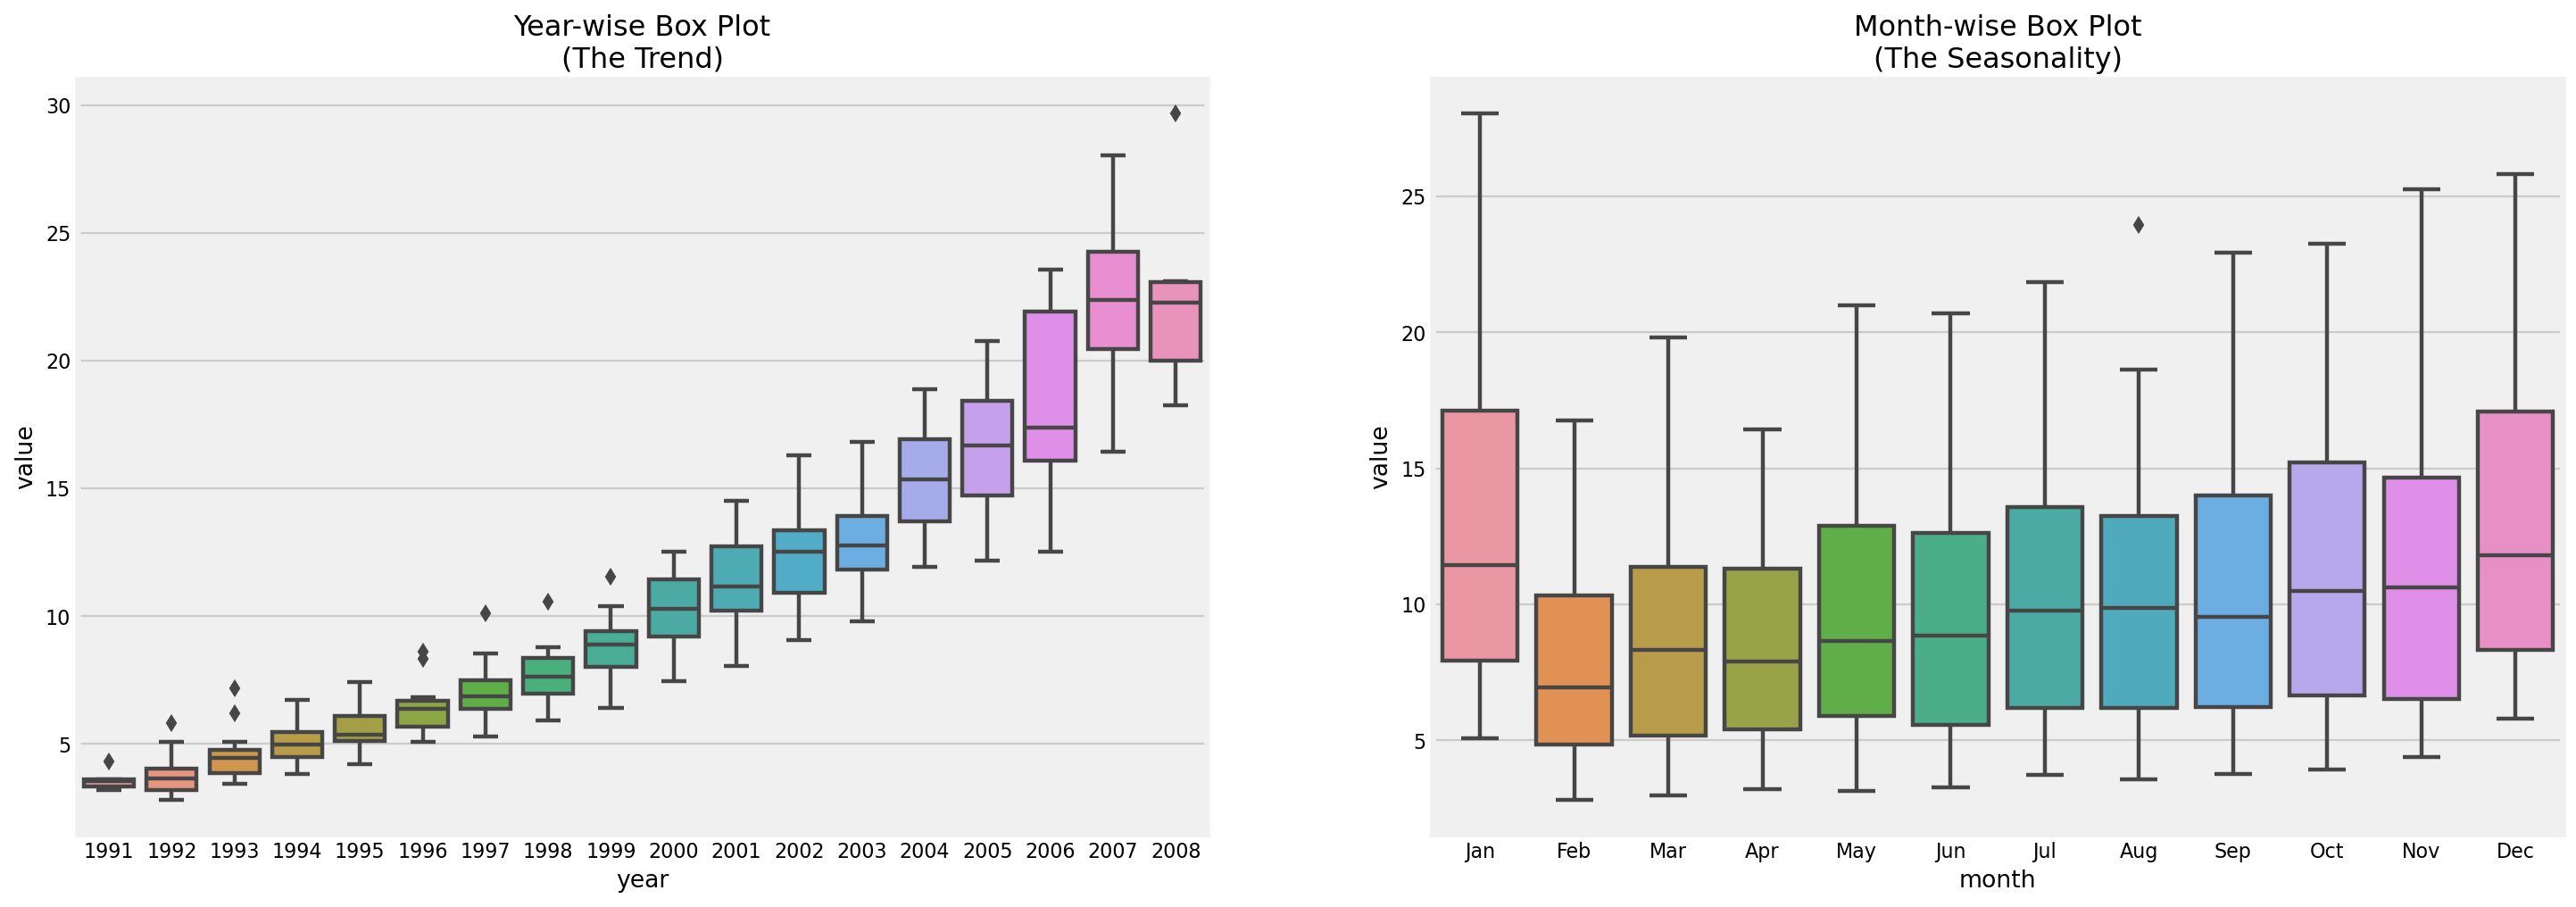

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=diabetic_drugs, ax=axes[0])
sns.boxplot(x='month', y='value', data=diabetic_drugs.loc[~diabetic_drugs.year.isin([1991, 2008]), :])

axes[0].set_title('Year-wise Box Plot\n(The Trend)'); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)')
plt.show()

## Additive and Multiplicative Time Series
Depending on the nature of the trend and seasonality, a time series can be modeled as an additive time serie or as a multiplicative one depending on whether observations can be expressed as a sum (additive) or a product (multiplicative) of the components. Values of additive time series are the sum of a base level, a trend, a seasonality, and an error. Values of multiplicative time series are the product of a base level, a trend, a seasonality, and an error.

We can decompose a time series using an additive or a multiplicative model in its its different components: (1) base level, (2) trend, (3) seasonal index, and (3) the residual. The function *seasonal_decompose* from the *statsmodels* library performs seasonal decomposition using moving averages.

* Additive: try to model the series like a trend series + a seasonal series + a residual series. Three signals that sum together result in the original data. The goal is to fit these three components as best as we can from the data we have
* Multiplicative: instead of the sum we multiply these three components.

residuals = observations - (seasonal + trend)

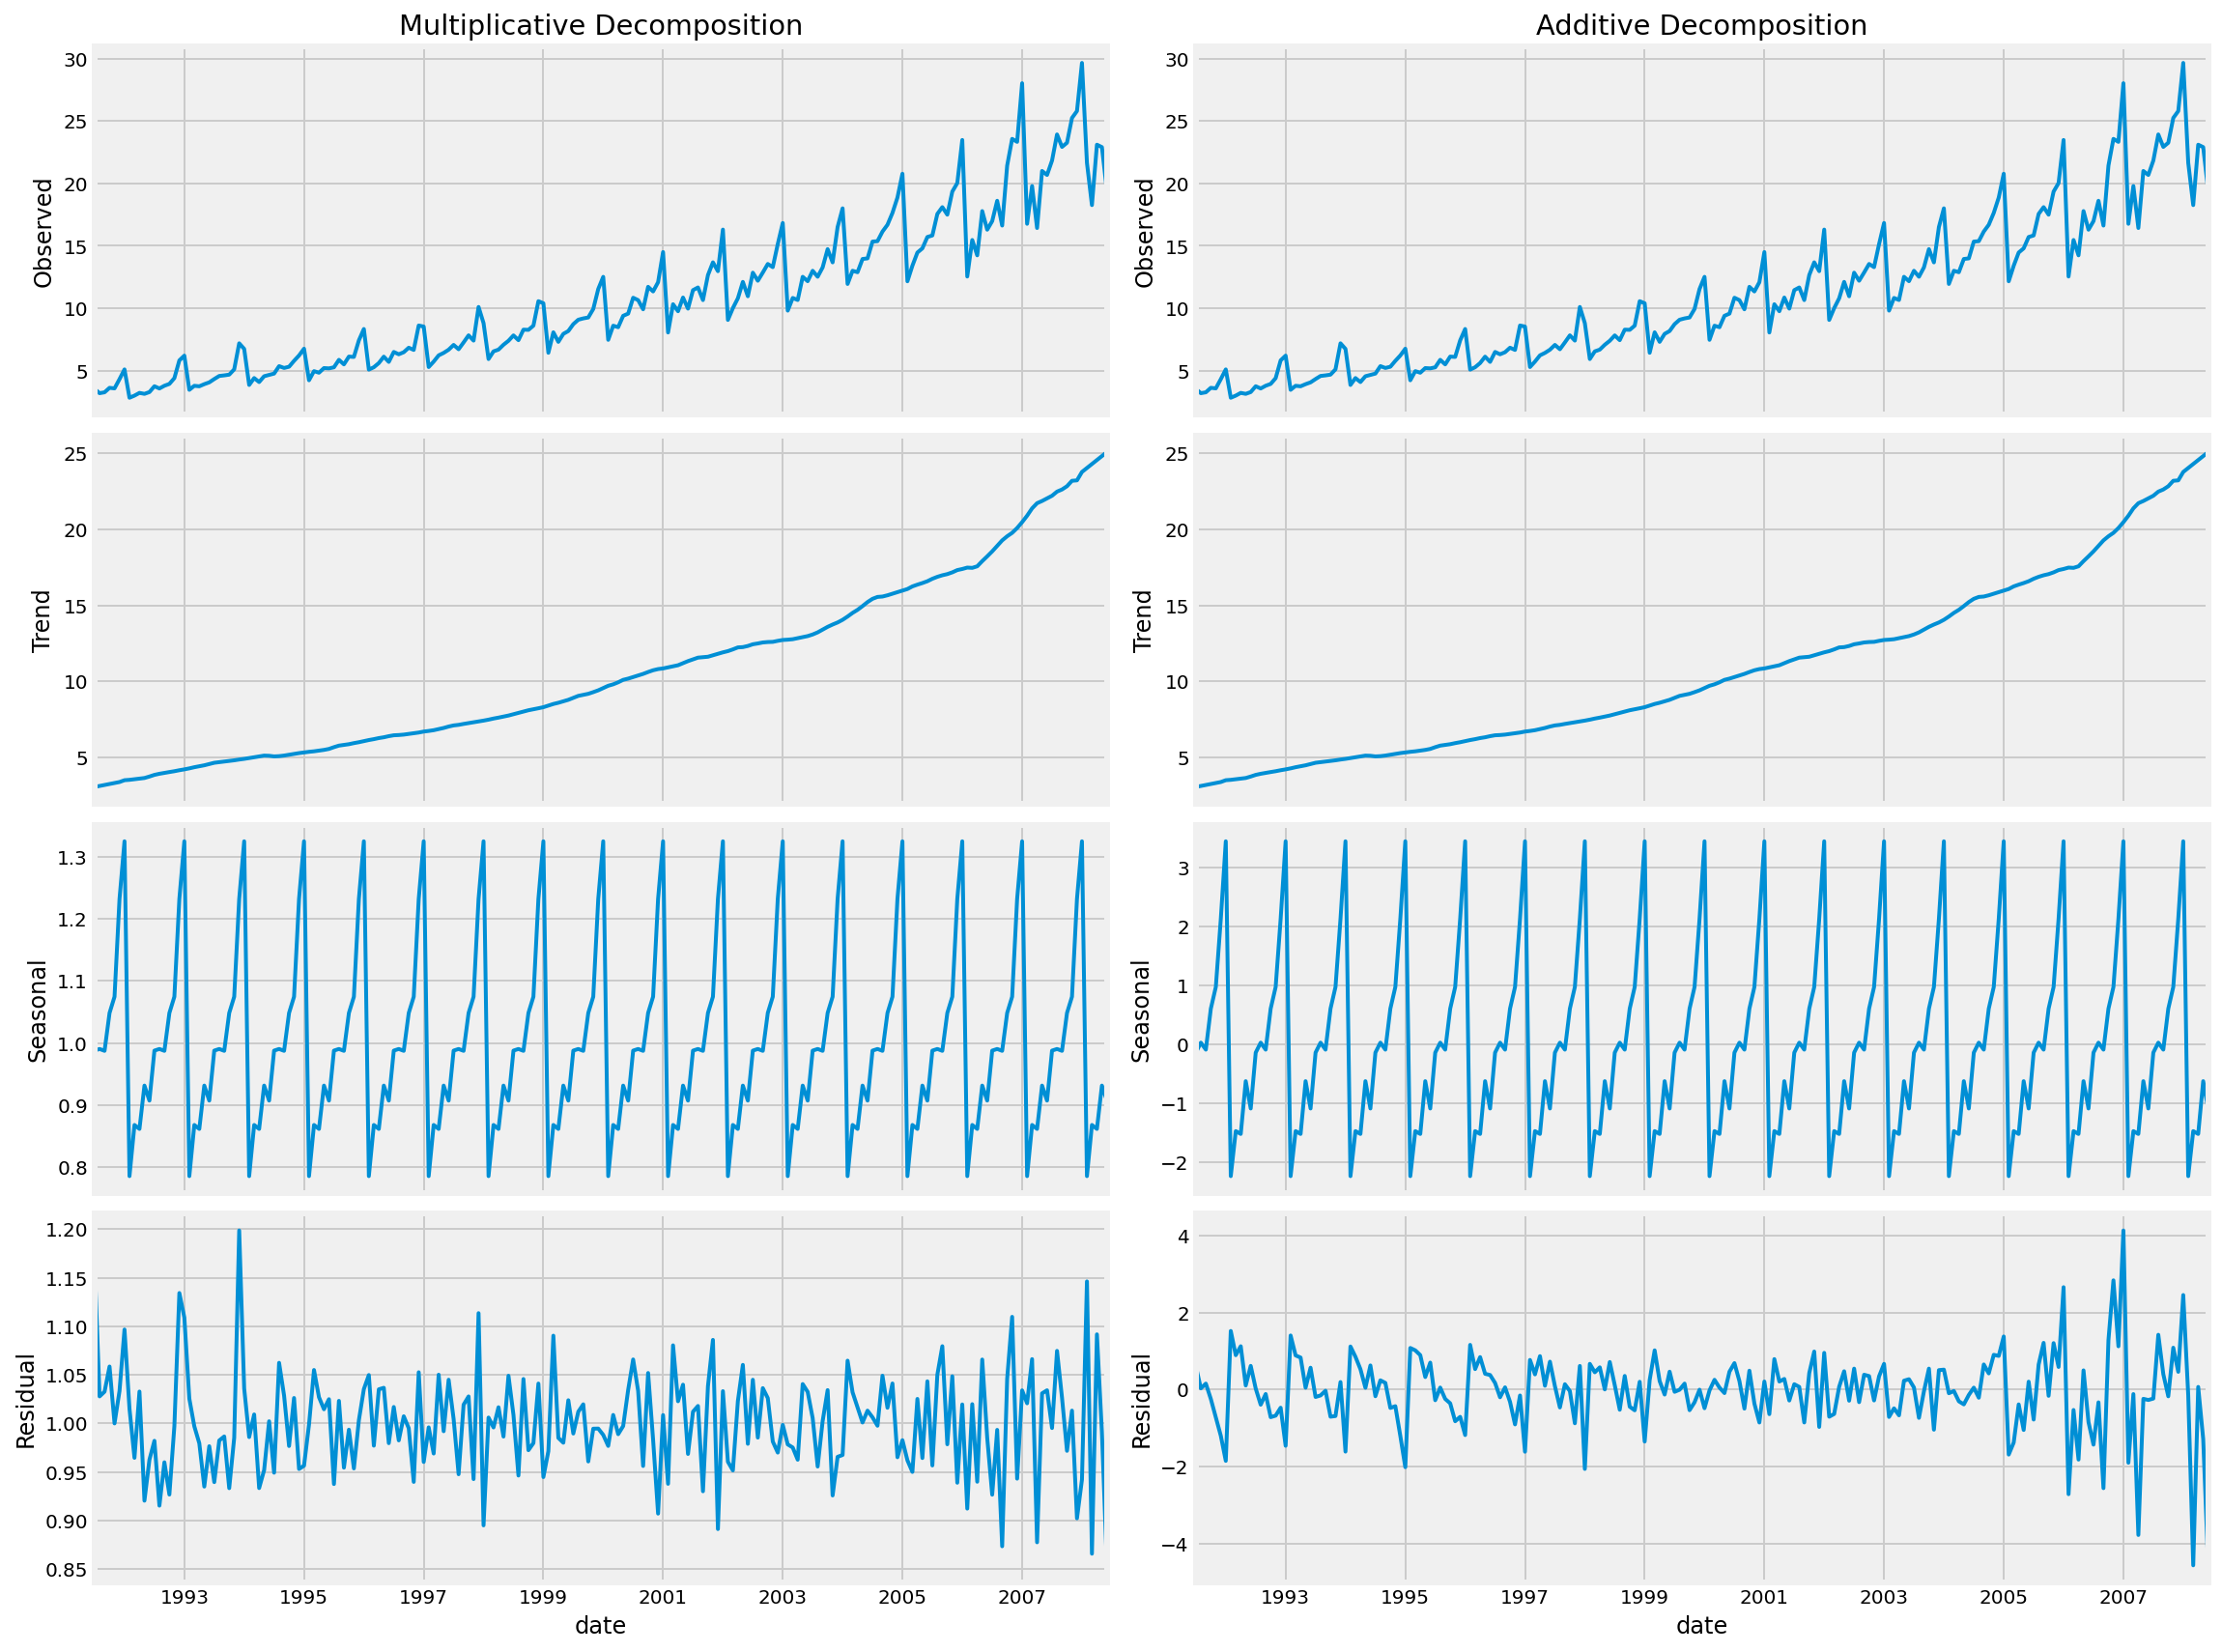

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

diabetic_drugs_series = pd.read_csv('others/a10.csv', parse_dates=['date'], index_col='date')

# freq = use the period discovered
decomposition_multiplicative = seasonal_decompose(diabetic_drugs_series['value'], model='multiplicative', extrapolate_trend='freq')
decomposition_additive = seasonal_decompose(diabetic_drugs_series['value'], model='additive', extrapolate_trend='freq')

# We define a function to be able to customize the single plots if we want.
# Alternatively, we can just call decomposition_multiplicative.plot()

def plotseasonal(decomposition, axes, title=""):
    decomposition.observed.plot(ax=axes[0], legend=False)
    axes[0].set_title(title)
    axes[0].set_ylabel('Observed')
    decomposition.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    decomposition.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    decomposition.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,12))
plotseasonal(decomposition_multiplicative, axes[:,0],"Multiplicative Decomposition")
plotseasonal(decomposition_additive, axes[:,1], "Additive Decomposition")
plt.tight_layout()
plt.show();

In the additive the ideal values for the residuals is 0. Residuals tell us how much error we made with respect to the true trend.

We want the residuals not to have a pattern because otherwise it means we can model better the signal we have.

Two cases:
1. Variance somehow constant over time: **additive** better
2. Variance varying during time (e.g., increasing during time): **multiplicative** better

In the multiplicative the residuals have somehow the same variance; this is not true in the residuals of the additive model.

Which is better? apply some statistics on the residuals. For instance, check if the residuals are stationary or not. If we have an unpredictable stationary residuals this is good since it means we already modeled properly trend and seasonality. This also means we cannot do better than this.

Let's assume residuals is a White-Noise signals (no correlations between any points in the sequence). If this is the case, we cannot do better: all the information is contained in the trend and seasonal signal. In the real world, this is not the general case. We are not able to decompose so ideally the data. So, if we can spot some seasonality or strange pattern in the residuals we can try to improve the model. 

## Time Series Manipulation
Most of the analysis of time series has to deal with date and time information. This is usually stored in files as plain strings, when we load the data we need to identify what information we are going to use as *time* in our data and what operations we might need to do on them. 

Let's load Google stock data from 2006 until 2018. We can simply load the data as a table as we did before

In [7]:
google = pd.read_csv('stocks/GOOGL_2006-01-01_to_2018-01-01.csv')
google.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


We can check the numerical attributes in the data,

In [8]:
google.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,428.200802,431.835618,424.130275,428.044001,3.551504e+06
std,236.320026,237.514087,234.923747,236.343238,3.038599e+06
min,131.390000,134.820000,123.770000,128.850000,5.211410e+05
25%,247.775000,250.190000,244.035000,247.605000,1.760854e+06
50%,310.480000,312.810000,307.790000,310.080000,2.517630e+06
75%,572.140000,575.975000,565.900000,570.770000,4.242182e+06
max,1083.020000,1086.490000,1072.270000,1085.090000,4.118289e+07


Or just the categorical one. Obviously, the attribute 'Name' is uniteresting since it has only one value 'GOOGL'; 'Date' on the other hand is a primary key as it has as many values as the number of data points.

In [9]:
google.describe(include=[np.object])

,Date,Name
count,3019,3019
unique,3019,1
top,2008-04-01,GOOGL
freq,1,3019


We can have a coincise summary of the loaded data frame by calling the function *info()*. 

In [10]:
google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB


Note that the Date attribute at the moment is just a string (type *object*). We want to use it as a time indicator so we transform the attribute 'Date' into an information about time by calling the function *to_datetime*.

In [11]:
google.Date = pd.to_datetime(google.Date)
google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3019 non-null   datetime64[ns]
 1   Open    3019 non-null   float64       
 2   High    3019 non-null   float64       
 3   Low     3019 non-null   float64       
 4   Close   3019 non-null   float64       
 5   Volume  3019 non-null   int64         
 6   Name    3019 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 165.2+ KB


We could now plot all the variables as time series

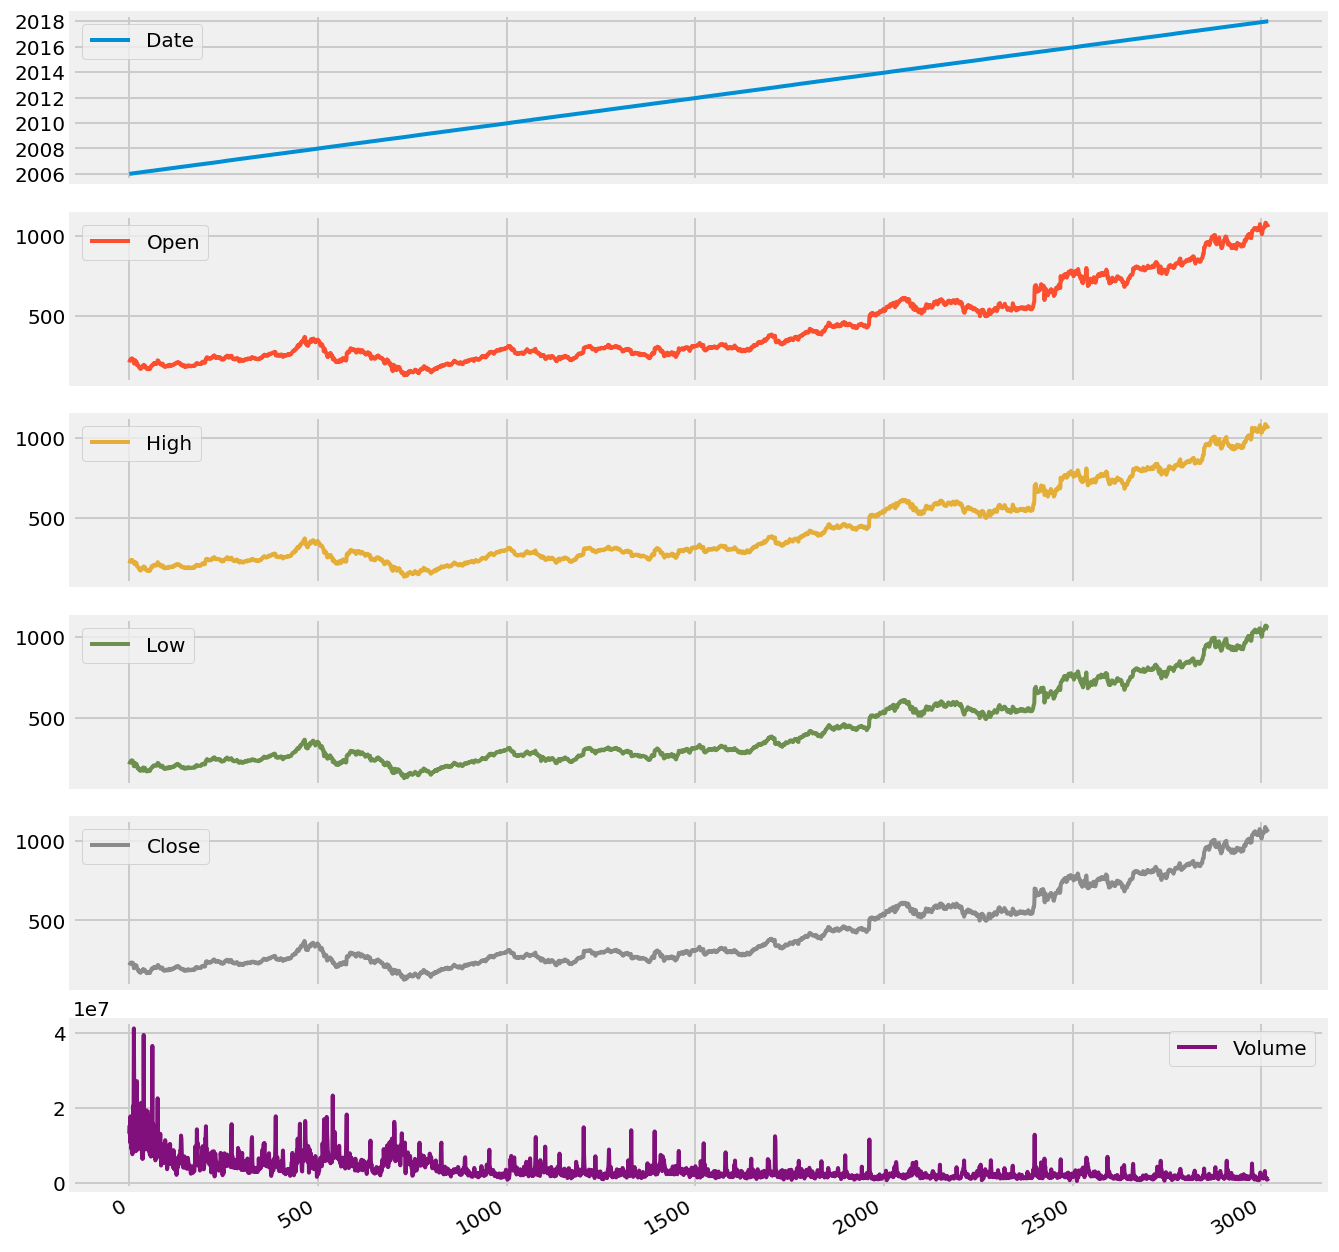

In [12]:
google.plot(subplots=True, figsize=(10,12));

But as you notice the plot is done according to the current dataframe index, an integer number from 0 to 3018 and the first plot is actually the index which results in straight line. The index of a panda dataframe is the one showed as bold when printing the table.

In [13]:
google.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


We want to use attribute 'Date' as the main index in our analysis, so we declare it as the index of the serie.

In [14]:
google.set_index('Date', inplace=True)
google.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


The same result could have been be achieved just with parse_date argument of the function read_csv

In [15]:
google = pd.read_csv('stocks/GOOGL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
google.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


We can now plot all the data using 'Date' as the main index

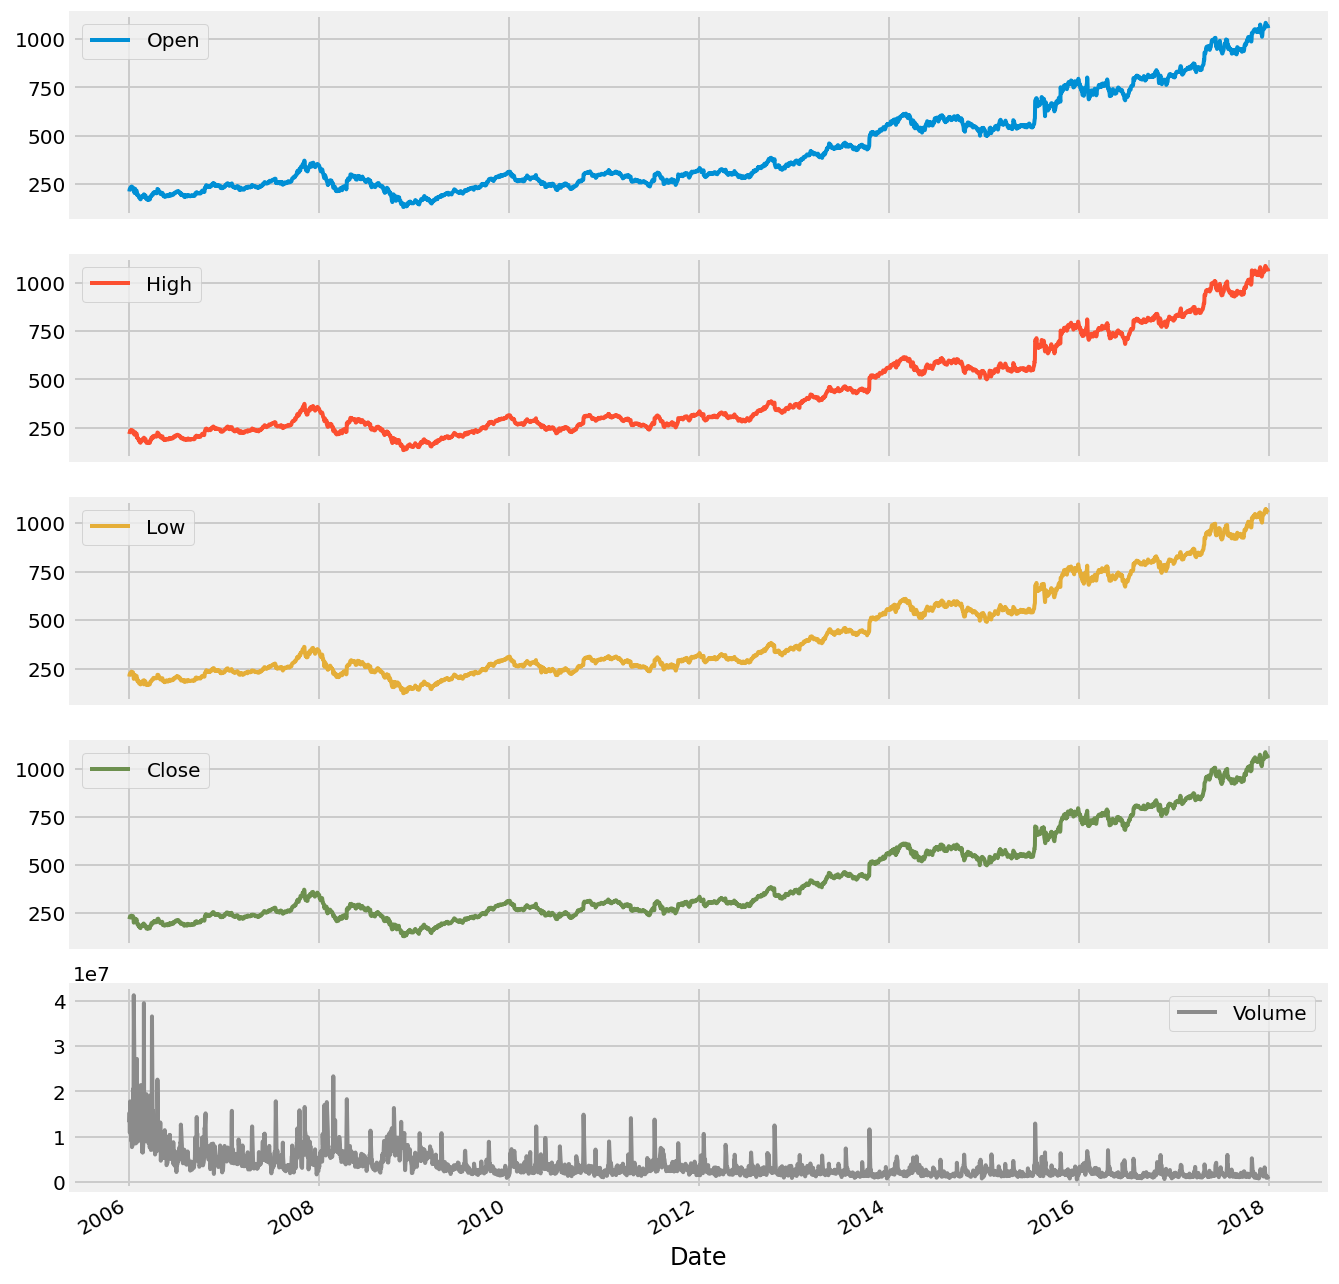

In [16]:
google.plot(subplots=True, figsize=(10,12));

We can plot only some of them for a specific period

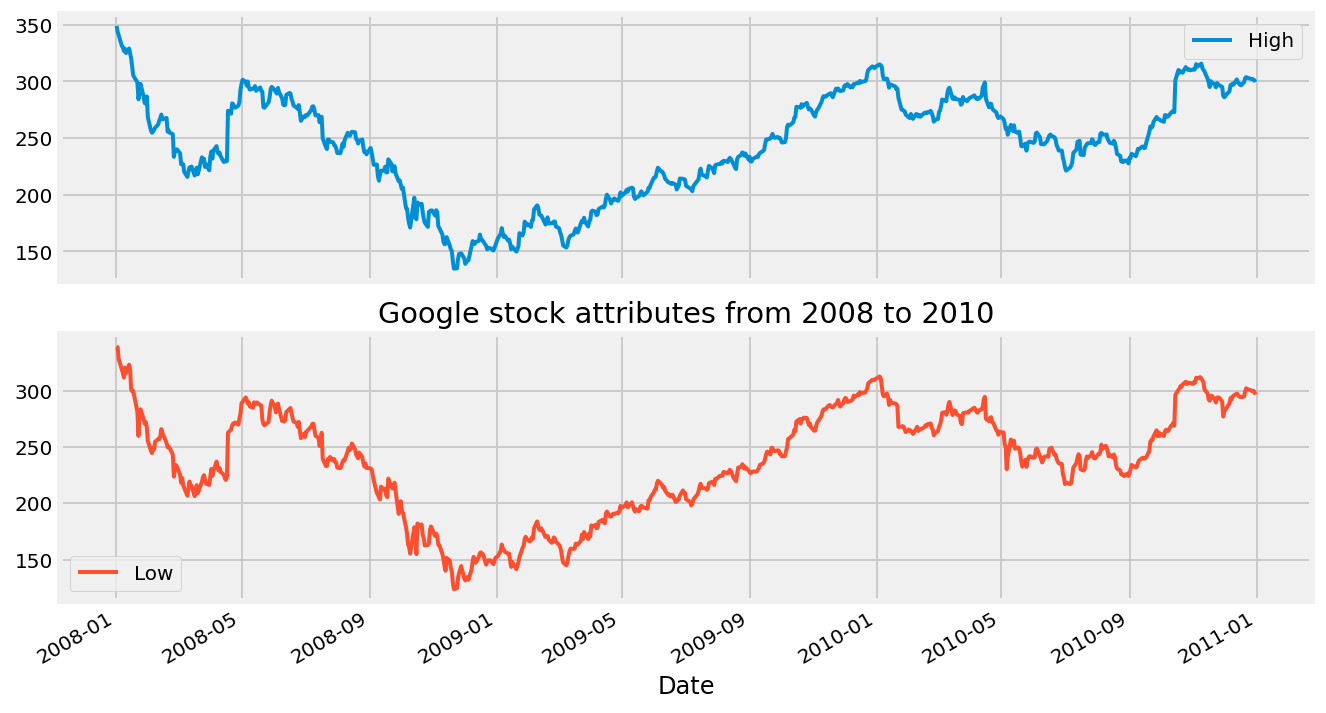

In [17]:
google[['High','Low']]['2008':'2010'].plot(subplots=True, figsize=(10,6))
plt.title('Google stock attributes from 2008 to 2010')
plt.savefig('stocks.png')
plt.show()

Having the index of *Datetime* type allows to select and resample data in several ways. We can select specific intervals and we can plot just one variable,

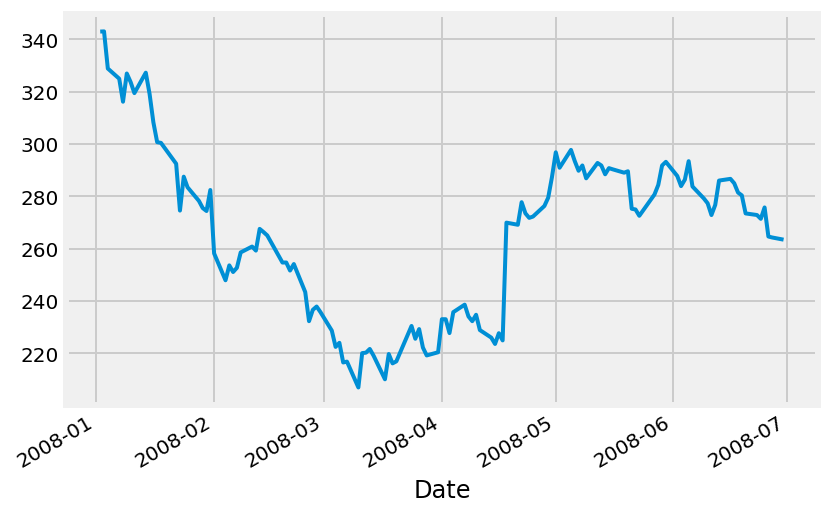

In [18]:
google['2008-1':'2008-6'].Close.plot()

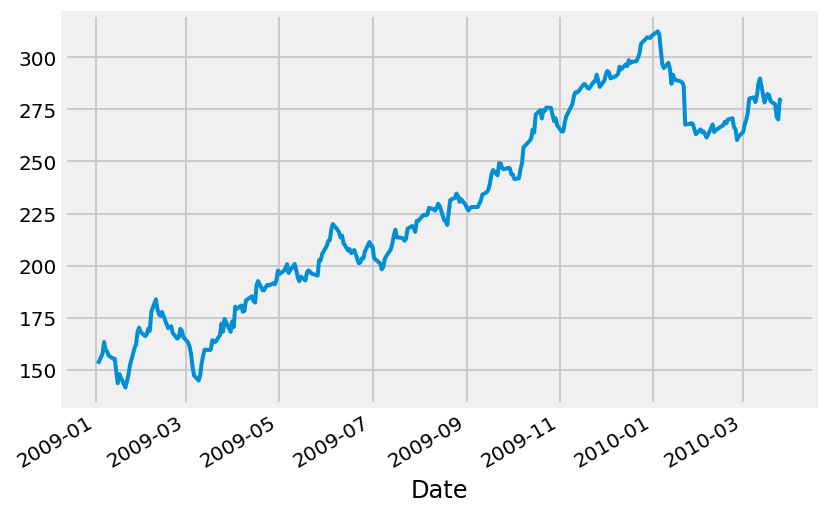

In [19]:
google['2009-1-1':'2010-3-26'].Low.plot()

We can sample the data to a certain frequency. We currently have 3019 data points collected daily, we can resample them as montly data, quaterly data, weekly data, etc. The method used (*asfreq*) takes as the main argument a date offset https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.tseries.offsets.DateOffset.html

For instance, we can resample the google data monthly and keep only the last day of the month.

Pick one point every month. From 3019, now we have 143 data points.

In [20]:
google_monthly = google.asfreq('M')
google_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2006-01-31 to 2017-11-30
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    102 non-null    float64
 1   High    102 non-null    float64
 2   Low     102 non-null    float64
 3   Close   102 non-null    float64
 4   Volume  102 non-null    float64
 5   Name    102 non-null    object 
dtypes: float64(5), object(1)
memory usage: 7.8+ KB


However, we might have values that are missing since we have no data for that specific day, as for instance it happens for September 30, 2017.

If there is not data-points in a specifc month then we will have missing data on that data point.

In [21]:
google_monthly.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-07-31,960.00,961.19,941.72,945.50,2293389.0,GOOGL
2017-08-31,946.30,957.20,946.25,955.24,1693313.0,GOOGL
2017-09-30,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-31,1033.00,1041.00,1026.30,1033.04,1516278.0,GOOGL
2017-11-30,1039.94,1044.14,1030.07,1036.17,2254590.0,GOOGL


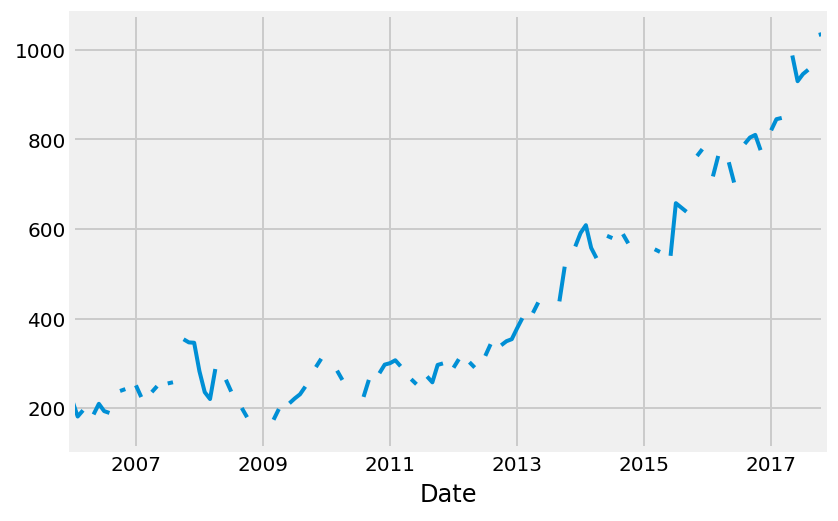

In [22]:
google_monthly.Close.plot();

We might use the start of the month, but still face the same issue for a different month.

In [23]:
google_monthly = google.asfreq('MS')
google_monthly.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-08-01,947.81,954.49,944.96,946.56,1332456.0,GOOGL
2017-09-01,957.47,958.33,950.28,951.99,1042885.0,GOOGL
2017-10-01,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-01,1036.32,1047.86,1034.00,1042.60,2163073.0,GOOGL
2017-12-01,1030.41,1037.24,1016.90,1025.07,1888081.0,GOOGL


<AxesSubplot:xlabel='Date'>

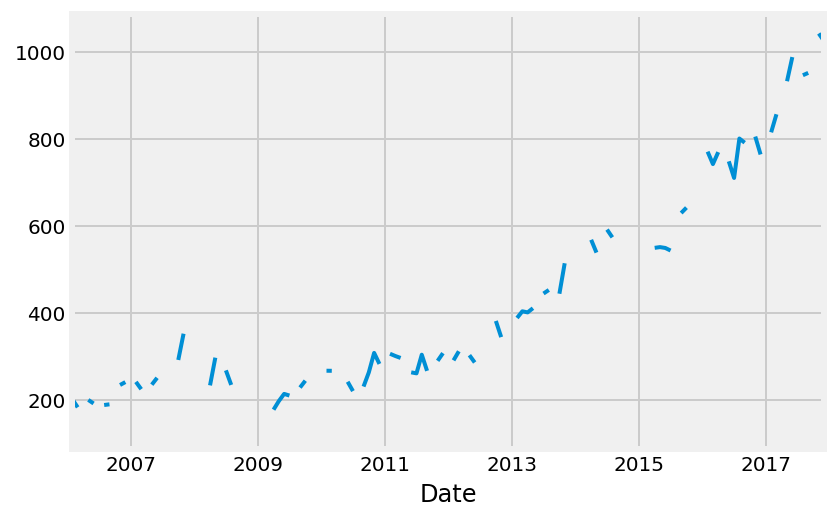

In [24]:
google_monthly.Close.plot()

We can fill missing data using three main strategies, 
- 'pad'/'ffill' propagates the last valid observation forward to next valid
- 'backfill'/'bfill' uses the next valid observation to fill
- 'fill_value' uses a specific value

In [25]:
google_monthly_zero = google.asfreq('M', fill_value=0)
google_quaterly_bfill = google.asfreq('Q', method='bfill')
google_yearly_ffill = google.asfreq('Y', method='ffill')

<AxesSubplot:xlabel='Date'>

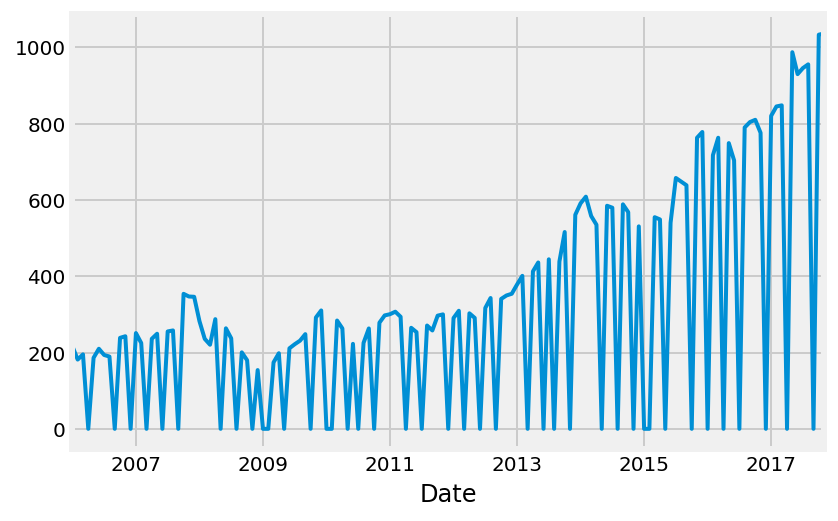

In [26]:
google_monthly_zero.Close.plot()

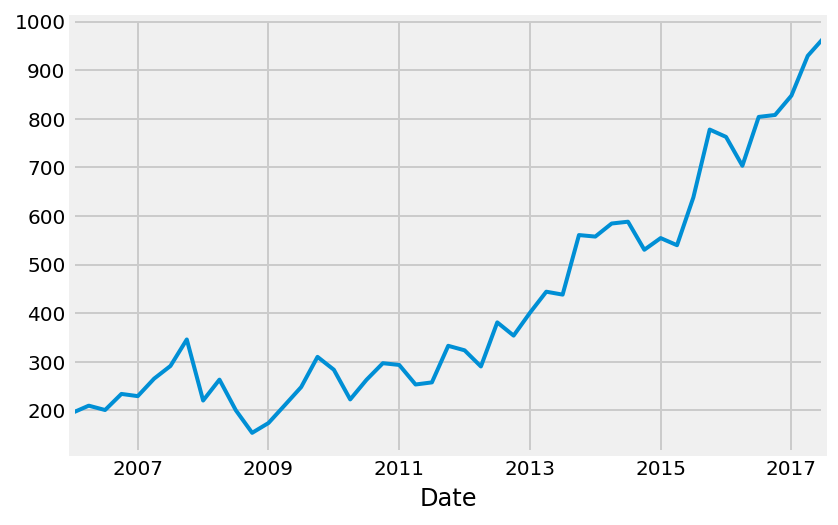

In [27]:
google_quaterly_bfill.Close.plot();

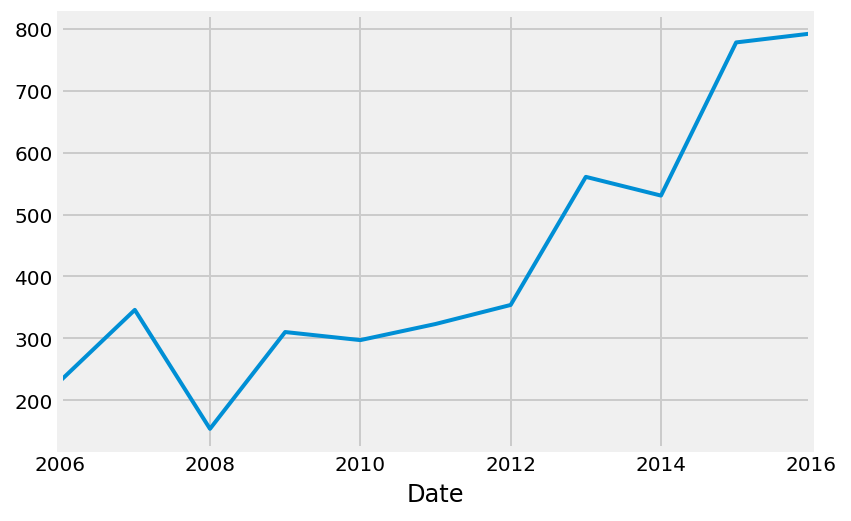

In [28]:
google_yearly_ffill.Close.plot();

We can resample the data and compute each point as a function of the sampled period. So for instance, we can plot the average closing price of every year, or the average closing price of every quarter.

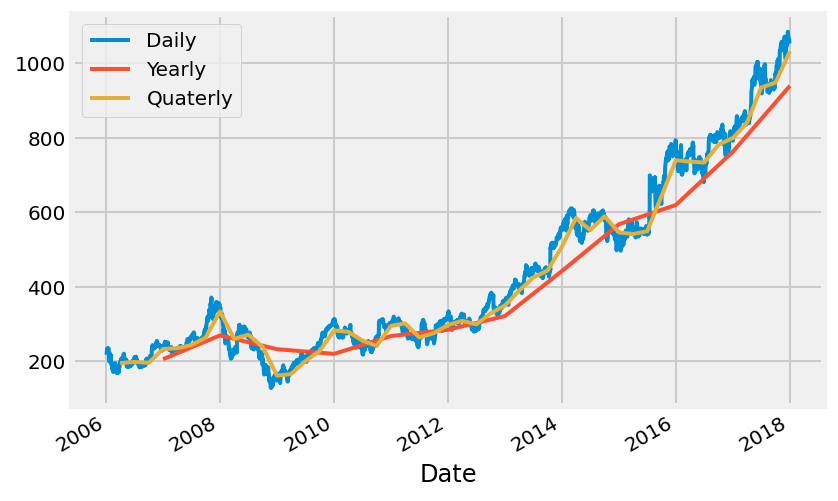

In [29]:
google_yearly = google.resample('Y').mean()
google_quaterly = google.resample('Q').mean()
google.Close.plot(label="Daily")
google_yearly.Close.plot(label="Yearly")
google_quaterly.Close.plot(label="Quaterly")
plt.legend()

There are also several functions that work over moving (rolling) windows. For example, instead of using the raw data of the closing price, we can use, for each day, the average of the 30 previous points.

In [30]:
google['Close Rolling Window'] = google['Close'].rolling(window=90).mean()

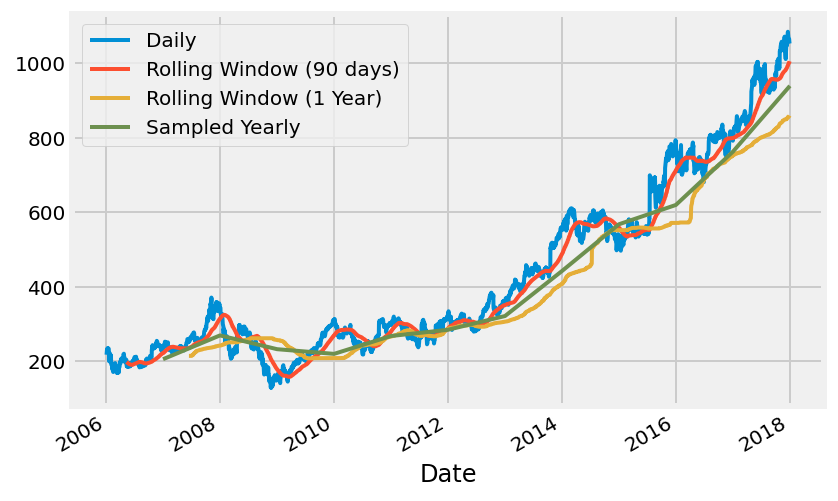

In [31]:
google.Close.plot(label="Daily")
google['Close Rolling Window'].plot(label="Rolling Window (90 days)")
google['Close'].rolling(window=365).median().plot(label="Rolling Window (1 Year)")
google_yearly.Close.plot(label="Sampled Yearly")
plt.legend();

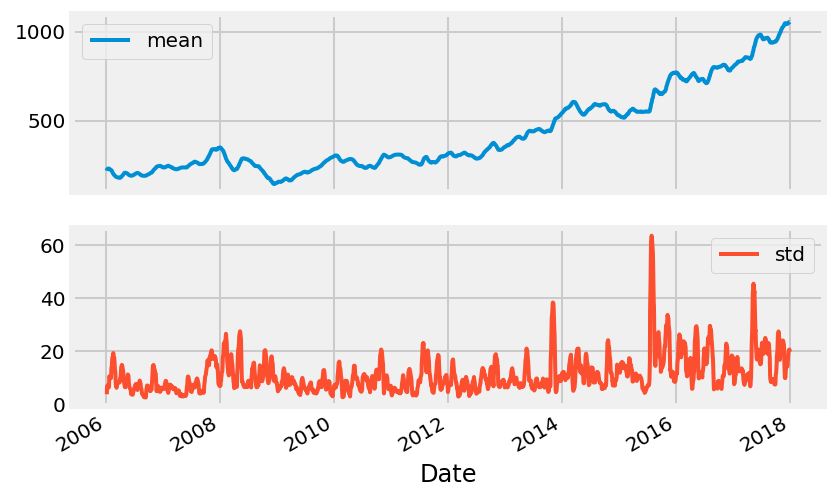

In [32]:
# D = Days
google['Close'].rolling(window='30D').agg(['mean', 'std']).plot(subplots=True);

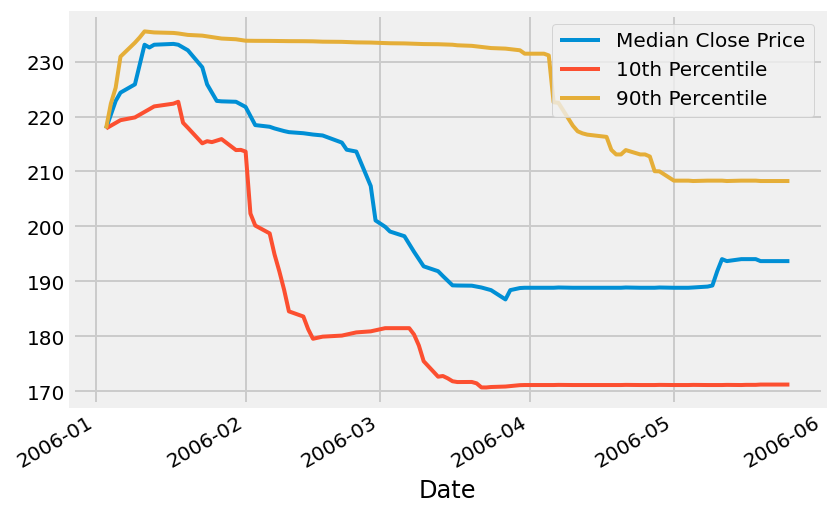

In [33]:
rolling_close_price = google['Close'].rolling('90D')
rolling_close_data = rolling_close_price.median().to_frame('Median Close Price')
rolling_close_data['10th Percentile'] = rolling_close_price.quantile(.1)
rolling_close_data['90th Percentile'] = rolling_close_price.quantile(.9)
rolling_close_data.head(100).plot();

We can shift the series forward and backward by a given amount. So for instance we can shift the data for attribute "Closed" by one day forward, two days back, or we can shift the same serie after it has been 

In [34]:
google['Shifted'] = google.Close.shift() 
google[['Close','Shifted']].head()

,Close,Shifted
Date,,
2006-01-03,217.83,NaN
2006-01-04,222.84,217.83
2006-01-05,225.85,222.84
2006-01-06,233.06,225.85
2006-01-09,233.68,233.06


In [35]:
google['Shifted'] = google.Close.shift(periods=-2) 
google[['Close','Shifted']].head()

,Close,Shifted
Date,,
2006-01-03,217.83,225.85
2006-01-04,222.84,233.06
2006-01-05,225.85,233.68
2006-01-06,233.06,235.11
2006-01-09,233.68,236.05


In [36]:
google['Shifted'] = google.Close.asfreq('3D').shift()
google[['Close','Shifted']].head(15)

,Close,Shifted
Date,,
2006-01-03,217.83,NaN
2006-01-04,222.84,NaN
2006-01-05,225.85,NaN
2006-01-06,233.06,217.83
2006-01-09,233.68,233.06
2006-01-10,235.11,NaN
2006-01-11,236.05,NaN
2006-01-12,232.05,233.68
2006-01-13,233.36,NaN


We can compute the difference between series like for instance $x_t$ and $x_{t-1}$.

Good way to make a non-stationary series to be stationary.

In [37]:
google['Shifted'] = google.Close.shift()
google['Diff'] = google.Close - google.Shifted #x_t - x_{t-1}
google[['Close','Diff']].head()

,Close,Diff
Date,,
2006-01-03,217.83,NaN
2006-01-04,222.84,5.01
2006-01-05,225.85,3.01
2006-01-06,233.06,7.21
2006-01-09,233.68,0.62


In [38]:
# same result with one command
google['Diff2'] = google['Close'].diff()
google[['Close','Diff','Diff2']].head()

,Close,Diff,Diff2
Date,,,
2006-01-03,217.83,NaN,NaN
2006-01-04,222.84,5.01,5.01
2006-01-05,225.85,3.01,3.01
2006-01-06,233.06,7.21,7.21
2006-01-09,233.68,0.62,0.62


We can compute the percentage change $(x_t - x_{t-1})/x_{t-1}$ using *pct_change()* function.

In [39]:
google['PCT Change'] = google.Close.pct_change()
google[['Close','Diff','PCT Change']].head()

,Close,Diff,PCT Change
Date,,,
2006-01-03,217.83,NaN,NaN
2006-01-04,222.84,5.01,0.023000
2006-01-05,225.85,3.01,0.013507
2006-01-06,233.06,7.21,0.031924
2006-01-09,233.68,0.62,0.002660


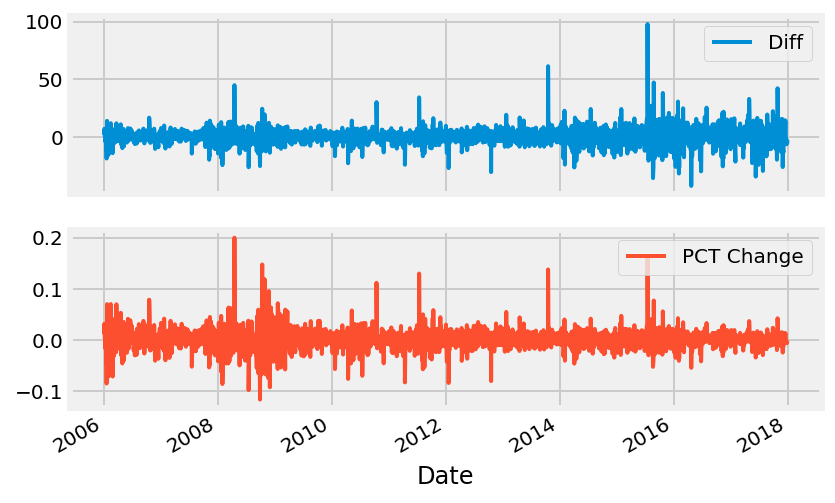

In [40]:
google[['Diff','PCT Change']].plot(subplots=True);